# Digit Recognizer on MNIST Dataset

# Data Overview

Source - [MNIST Data Set](http://yann.lecun.com/exdb/mnist/)

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.


# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

# Reading Data

In [2]:
# Load the data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [3]:
print('Train Dataset')
print('\n','-'*100,'\n')
print(train.sample(20))
print('\n','-'*100,'\n')
print(train.shape)
print('\n','-'*190,'\n')
print(train.info())
print('\n','-'*100,'\n')

print('\n\n','*'*100,'\n\n')

print('Test Dataset')
print('\n','-'*100,'\n')
print(test.sample(20))
print('\n','-'*100,'\n')
print(test.shape)
print('\n','-'*100,'\n')
print(test.info())
print('\n','-'*100,'\n')

Train Dataset

 ---------------------------------------------------------------------------------------------------- 

       label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
38732      6       0       0       0       0       0       0       0       0   
3686       9       0       0       0       0       0       0       0       0   
30090      5       0       0       0       0       0       0       0       0   
31205      7       0       0       0       0       0       0       0       0   
11331      9       0       0       0       0       0       0       0       0   
22883      2       0       0       0       0       0       0       0       0   
26503      3       0       0       0       0       0       0       0       0   
27313      3       0       0       0       0       0       0       0       0   
35521      7       0       0       0       0       0       0       0       0   
40140      0       0       0       0       0       0       0       0       0   
2

# Data Pre-Processing and Exploration

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

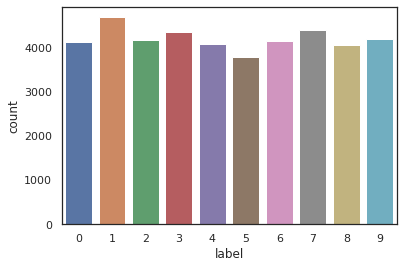

In [4]:
Y_train = train["label"]

X_train = train.drop(labels = ["label"],axis = 1) 

del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

In [5]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
X_train = X_train / 255.0
test = test / 255.0

In [8]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [9]:
Y_train = to_categorical(Y_train, num_classes = 10)

In [10]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=0)

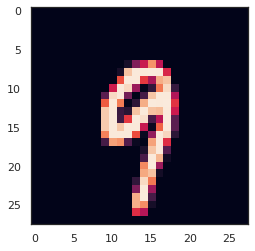

In [11]:
g = plt.imshow(X_train[100][:,:,0])

# CNN Modelling

In [12]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [13]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [14]:
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [16]:
epochs = 30
batch_size = 86

In [17]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

datagen.fit(X_train)

In [18]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = 10, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/10
439/439 - 12s - loss: 0.4133 - accuracy: 0.8681 - val_loss: 0.0764 - val_accuracy: 0.9755
Epoch 2/10
439/439 - 13s - loss: 0.1330 - accuracy: 0.9604 - val_loss: 0.0447 - val_accuracy: 0.9871
Epoch 3/10
439/439 - 13s - loss: 0.0980 - accuracy: 0.9703 - val_loss: 0.0345 - val_accuracy: 0.9895
Epoch 4/10
439/439 - 12s - loss: 0.0789 - accuracy: 0.9776 - val_loss: 0.0427 - val_accuracy: 0.9876
Epoch 5/10
439/439 - 12s - loss: 0.0732 - accuracy: 0.9780 - val_loss: 0.0339 - val_accuracy: 0.9895
Epoch 6/10
439/439 - 12s - loss: 0.0658 - accuracy: 0.9808 - val_loss: 0.0309 - val_accuracy: 0.9905
Epoch 7/10
439/439 - 13s - loss: 0.0585 - accuracy: 0.9827 - val_loss: 0.0255 - val_accuracy: 0.9919
Epoch 8/10
439/439 - 12s - loss: 0.0558 - accuracy: 0.9839 - val_loss: 0.0271 - val_accuracy: 0.9919
Epoch 9/10
439/439 - 12s - loss: 0.0531 - accuracy: 0.9847 - val_loss: 0.0235 - val_accuracy: 0.9938
Epoch 10/10
439/439 - 12s - loss: 0.0495 - accuracy: 0.9850 - val_loss: 0.0278 - val_accura

# Results

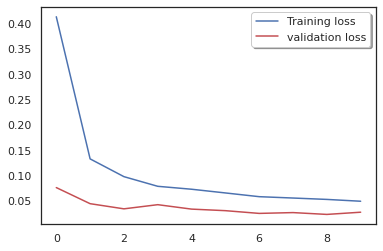

In [19]:
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.legend(loc='best', shadow=True)
plt.show()

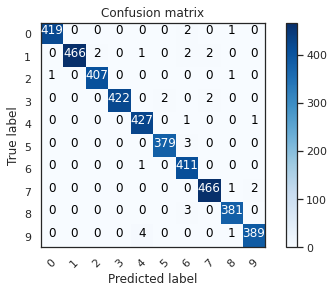

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [22]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [23]:
final = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)